In [2]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import efc_2dm as efc
from wfsc import utils

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')


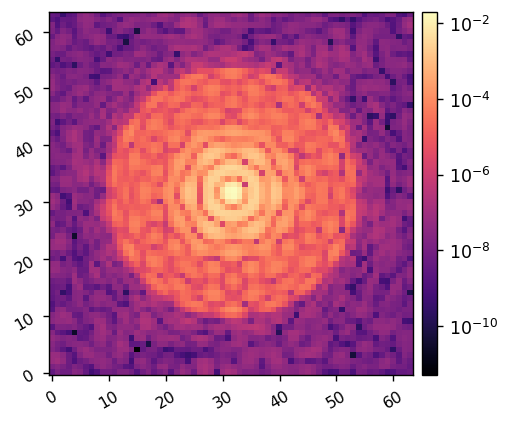

0.020081468425845


In [3]:
reload(cgi)
sys = cgi.CGI(cgi_mode='hlc', 
              use_fpm=False,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )

unocc_psf = sys.snap()

misc.myimshow(unocc_psf, lognorm=True)
Imax_unocc = unocc_psf.max()
print(Imax_unocc)

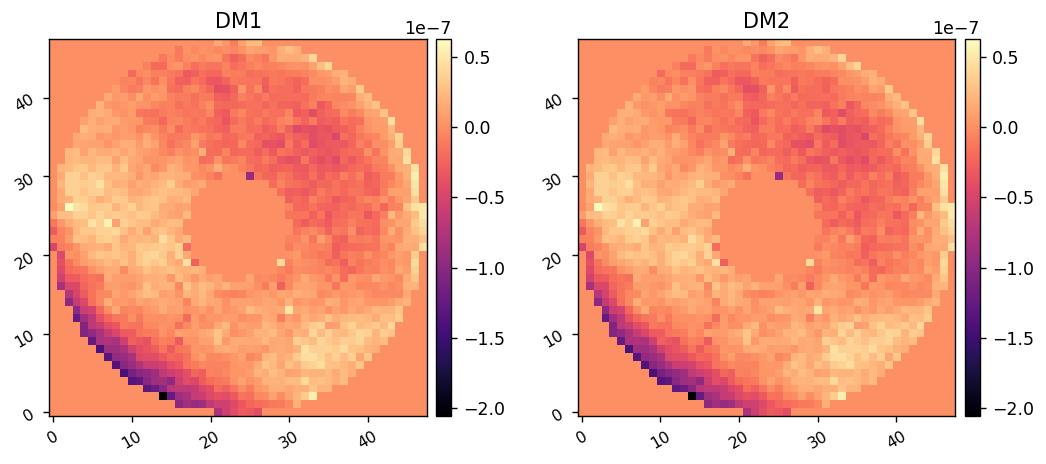

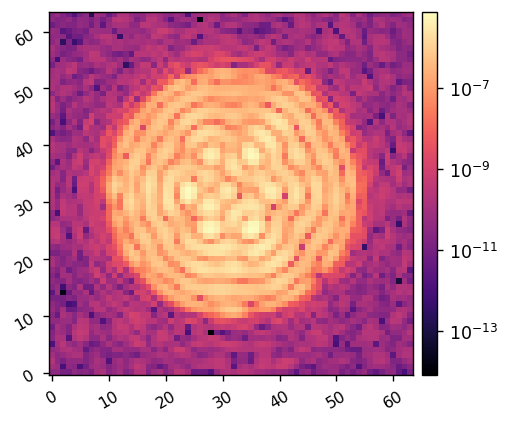

In [5]:
reload(cgi)
sys = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
sys.show_dms()

npsf = sys.npsf
Nact = sys.Nact

ref_psf = sys.snap()

misc.myimshow(ref_psf, lognorm=True)

# Create the dark-hole mask

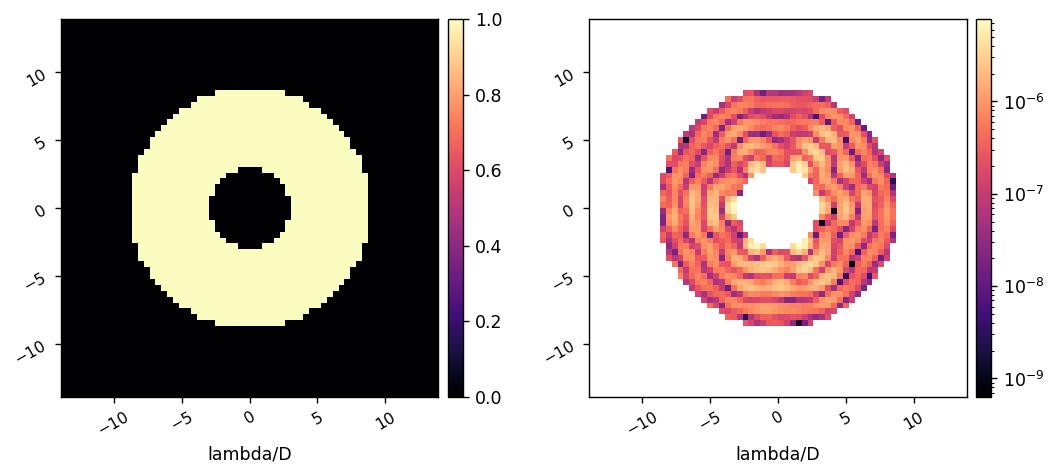

In [7]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * sys.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 0
iwa = 3
owa = 9
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
#     'direction' : '+x',
    'rotation':rot,
    'full':True
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params)

nmask = dh_mask.sum()

misc.myimshow2(dh_mask, ref_psf*dh_mask,  
               pxscl1=sys.psf_pixelscale_lamD, pxscl2=sys.psf_pixelscale_lamD,
               lognorm2=True)

In [5]:
# reload(efc)

# epsilon = 1e-9 # poke amplitudes (DM surface)
# jac = efc.build_jacobian(hlc, epsilon, dh_mask.flatten(), display=False)

In [6]:
# jac_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians')
# # fname = 'hlc_39_opds_flatmaps_2dm'
# fname = 'hlc_2dm'

# misc.save_pickle(jac_dir/fname, jac, quiet=False)

In [8]:
jac_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data/jacobians')
fname = 'hlc_39_opds_flatmaps_2dm'
# fname = 'hlc_2dm'

jac = misc.load_pickle(jac_dir/fname)
jac.shape, jac[:,:Nact**2].shape, jac[:,Nact**2:].shape

((2296, 4608), (2296, 2304), (2296, 2304))

In [10]:
nmask*2

2296

# Invert the Jacobian to get the control matrix

In [19]:
reload(utils)
reg_fun = utils.beta_reg
# reg_conds = np.array([[0, 10, 20, 30, 40, 50],
#                       [-3, -5, -1, -3, -4, -5]])
reg_conds = np.array([[0, 20, 25, 60, 65],
                      [0, -1, 0, -2, 0]])

# Run EFC with perfect model

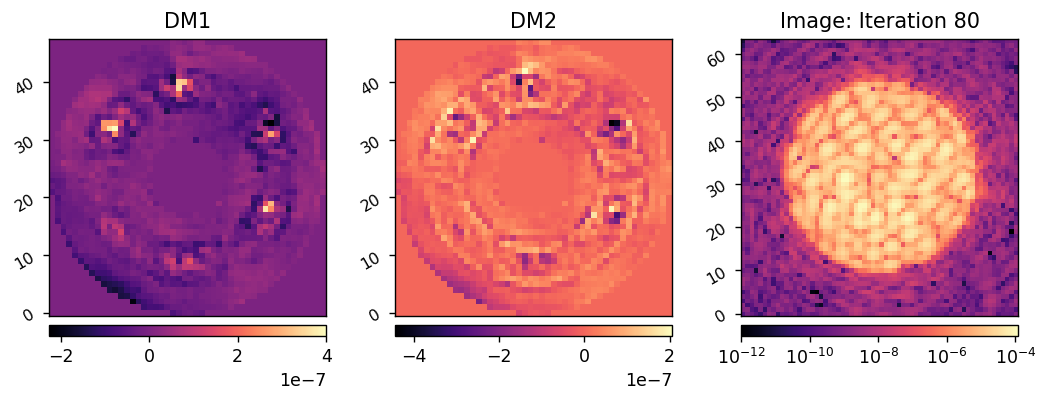

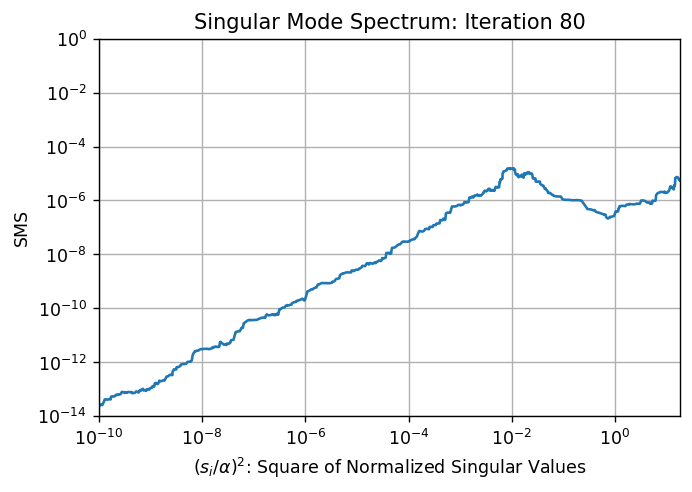

EFC completed in 90.444 sec.


In [20]:
reload(efc)
sys.reset_dms()
dm1_commands1, dm2_commands1, efields1 = efc.run_efc_perfect(sys,
                                                             jac,
                                                             reg_fun,
                                                             reg_conds,
                                                             dh_mask, 
                                                             Imax_unocc,
                                                             iterations=80, 
#                                                              display_all=True, 
                                                             plot_sms=True)